# Preprocessing pipeline


This pipeline aims to serve as a semiautomatic and reproducible framework for preprocessing EEG signals prior to time-frequency-based analyses. It minimizes the manual steps required to clean the data based on visual inspection. It is advised to revisit the cleaned epochs before writing the final preprocessed file. 


## Outline

1. Temporal filtering  
High-frequency artefacts and slow drifts are removed with a zero-phase bandpass filter using mne-Python [1]. The cutoff frequencies (0.5 - 45 Hz) can be modified in the utils folder in the configuration file (config.py). 

2. Create epochs
Epochs are nonoverlapping data segments created from the continuous data with a duration of 1 seconds. The length of epochs can be changed in the configuration file.
Epochs can be created from (1) events; there is a custom method that created epochs based on annotations in the raw data, (2) without events, data segments are created from the beginning of the raw data. 

3. Outlier data rejection  
3.1. Preliminar rejection  
Epochs are rejected based on a global threshold on the z-score (> 3) of the epoch variance and amplitude range.
3.2. ICA decomposition  
The default method is the infomax algorithm, however it can be changed in the configuration file along with the number of components and the decimation parameter. Components containing blink artefacts are automatically marked with mne-Python.
The ICA sourced can be visualized and interactively selected and rejected based on their topographies, time-courses or frequency spectra. The number of components that were removed from the data are documented in the “description” field of the epochs instance “info” structure.
3.3. Autoreject
Autoreject [2, 3] uses unsupervised learning to estimate the rejection threshold for the epochs. In order to reduce computation time that increases with the number of segments and channels, autoreject can be fitted on a representative subset of epochs (25% of total epochs). Once the parameters are learned, the solution can be applied to any data that contains channels that were used during fit.
4. Outlier channel interpolation  
The Random Sample Consensus (RANSAC) algorithm [4] selects a random subsample of good channels to make predictions of each channel in small non-overlapping 4 seconds long time windows. It uses a method of spherical splines (Perrin et al., 1989) to interpolate the bad sensors. The sensors that were interpolated are added to the "description" field of the epochs "info" structure. 
5. Set average reference (optional)
Additionally, the EEG reference can be changed to a “virtual reference” that 
is the average of all channels using mne-Python.

## References

[1] A. Gramfort, M. Luessi, E. Larson, D. Engemann, D. Strohmeier, C. Brodbeck, R. Goj, M. Jas, T. Brooks, L. Parkkonen, M. Hämäläinen, MEG and EEG data analysis with MNE-Python, Frontiers in Neuroscience, Volume 7, 2013, ISSN 1662-453X

[2] Mainak Jas, Denis Engemann, Federico Raimondo, Yousra Bekhti, and Alexandre Gramfort, “Automated rejection and repair of bad trials in MEG/EEG.” In 6th International Workshop on Pattern Recognition in Neuroimaging (PRNI), 2016.

[3] Mainak Jas, Denis Engemann, Yousra Bekhti, Federico Raimondo, and Alexandre Gramfort. 2017. “Autoreject: Automated artifact rejection for MEG and EEG data”. NeuroImage, 159, 417-429.

[4] Bigdely-Shamlo, N., Mullen, T., Kothe, C., Su, K. M., & Robbins, K. A. (2015). The PREP pipeline: standardized preprocessing for large-scale EEG analysis. Frontiers in neuroinformatics, 9, 16.



## Import packages


```%matplotlib qt``` is the recommended backend for interactive visualization (can be slower);    

switch to ```%matplotlib inline``` for (faster) static plots

In [1]:
import os
from pathlib import Path
from ipyfilechooser import FileChooser

from eeg_preprocessing.preprocessing import *
from eeg_preprocessing.utils.epochs import create_epochs
from eeg_preprocessing.utils.raw import read_raw_measurement

%matplotlib qt

## Load raw data


See [this](https://mne.tools/stable/auto_tutorials/io/20_reading_eeg_data.html) documentation for help with supported file formats.  

In [2]:
# Use the widget to navigate to the experiment folder path and select an EEG file 
fc = FileChooser()
fc.filter_pattern = ['*.vhdr', '*.edf']

display(fc)

FileChooser(path='/Users/weian/crnl/eeg-preprocessing/tutorials', filename='', title='HTML(value='', layout=La…

In [3]:
# Load selected file
base_path = Path(fc.selected).parent

locs_file_path = '/Users/weian/crnl/neuroelectrics_eeg_pilot/Starstim32.locs'
raw = read_raw_measurement(raw_file_path=fc.selected,
                           locs_file_path=locs_file_path, add_info=False)
print(raw.info)

Extracting EDF parameters from /Volumes/crnl-memo-hd/raw_data_EEG/20210422171216_3_EEG PALT alatt.easy_converted_.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Channel locations are missing from the file
There are 3 channel positions not present in the Starstim32 file.
Assuming these (['X', 'Y', 'Z']) are not EEG channels, dropping them from Raw.
Applying channel locations to Raw instance.
<Info | 9 non-empty values
 bads: []
 ch_names: P8, T8, F8, F4, C4, P4, Fp2, Fp1, Fz, Cz, O1, Oz, O2, Pz, P3, ...
 chs: 20 EEG
 custom_ref_applied: False
 dig: 20 items (20 EEG)
 fid: 20210422171216_3_EEG PALT alatt.easy_converted_
 highpass: 0.1 Hz
 lowpass: 250.0 Hz
 meas_date: 2021-04-22 17:12:25 UTC
 nchan: 20
 projs: []
 sfreq: 500.0 Hz
>


##  Create epochs

Here we apply different cutoff frequencies than the default (0.5 - 45 Hz).

In [4]:
from eeg_preprocessing.utils.config import settings

settings['bandpass_filter']['low_freq'] = 1
settings['bandpass_filter']['high_freq'] = 30

In [5]:
epochs = create_epochs(raw=raw)

Reading 0 ... 50999  =      0.000 ...   101.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1651 samples (3.302 sec)



[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Creating epochs from continuous data ...
Not setting metadata
Not setting metadata
102 matching events found
No baseline correction applied
0 projection items activated
Loading data for 102 events and 500 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=8)]: Done  10 tasks      | elapsed:    5.1s
[Parallel(n_jobs=8)]: Done  18 out of  20 | elapsed:    5.1s remaining:    0.6s
[Parallel(n_jobs=8)]: Done  20 out of  20 | elapsed:    5.1s finished


## Run preprocessing


### 1.1. Preliminary epoch rejection

In [6]:
epochs_faster = prepare_epochs_for_ica(epochs=epochs)

Preliminary epoch rejection: 
Bad epochs by amplitude
	[ 77  78  79  80  94  96  97 101]
Bad epochs by deviation
	[ 95 101]
Bad epochs by variance
	[ 77  79  80  94  95  96  97 101]
Dropped 9 epochs: 77, 78, 79, 80, 94, 95, 96, 97, 101


### 1.2. Run ICA

Since this dataset only have 20 channels, the default number of components have to be adjusted. Similalry as before, we can change it here.

In [7]:
settings['ica']['n_components'] = 18

In [8]:
ica = run_ica(epochs=epochs_faster)

Fitting ICA to data using 20 channels (please be patient, this may take a while)
Selecting by number: 18 components
 
Fitting ICA took 3.4s.
EOG channels are not found. Attempting to use Fp1,Fp2 channels as EOG channels.


Not setting metadata
Not setting metadata
93 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


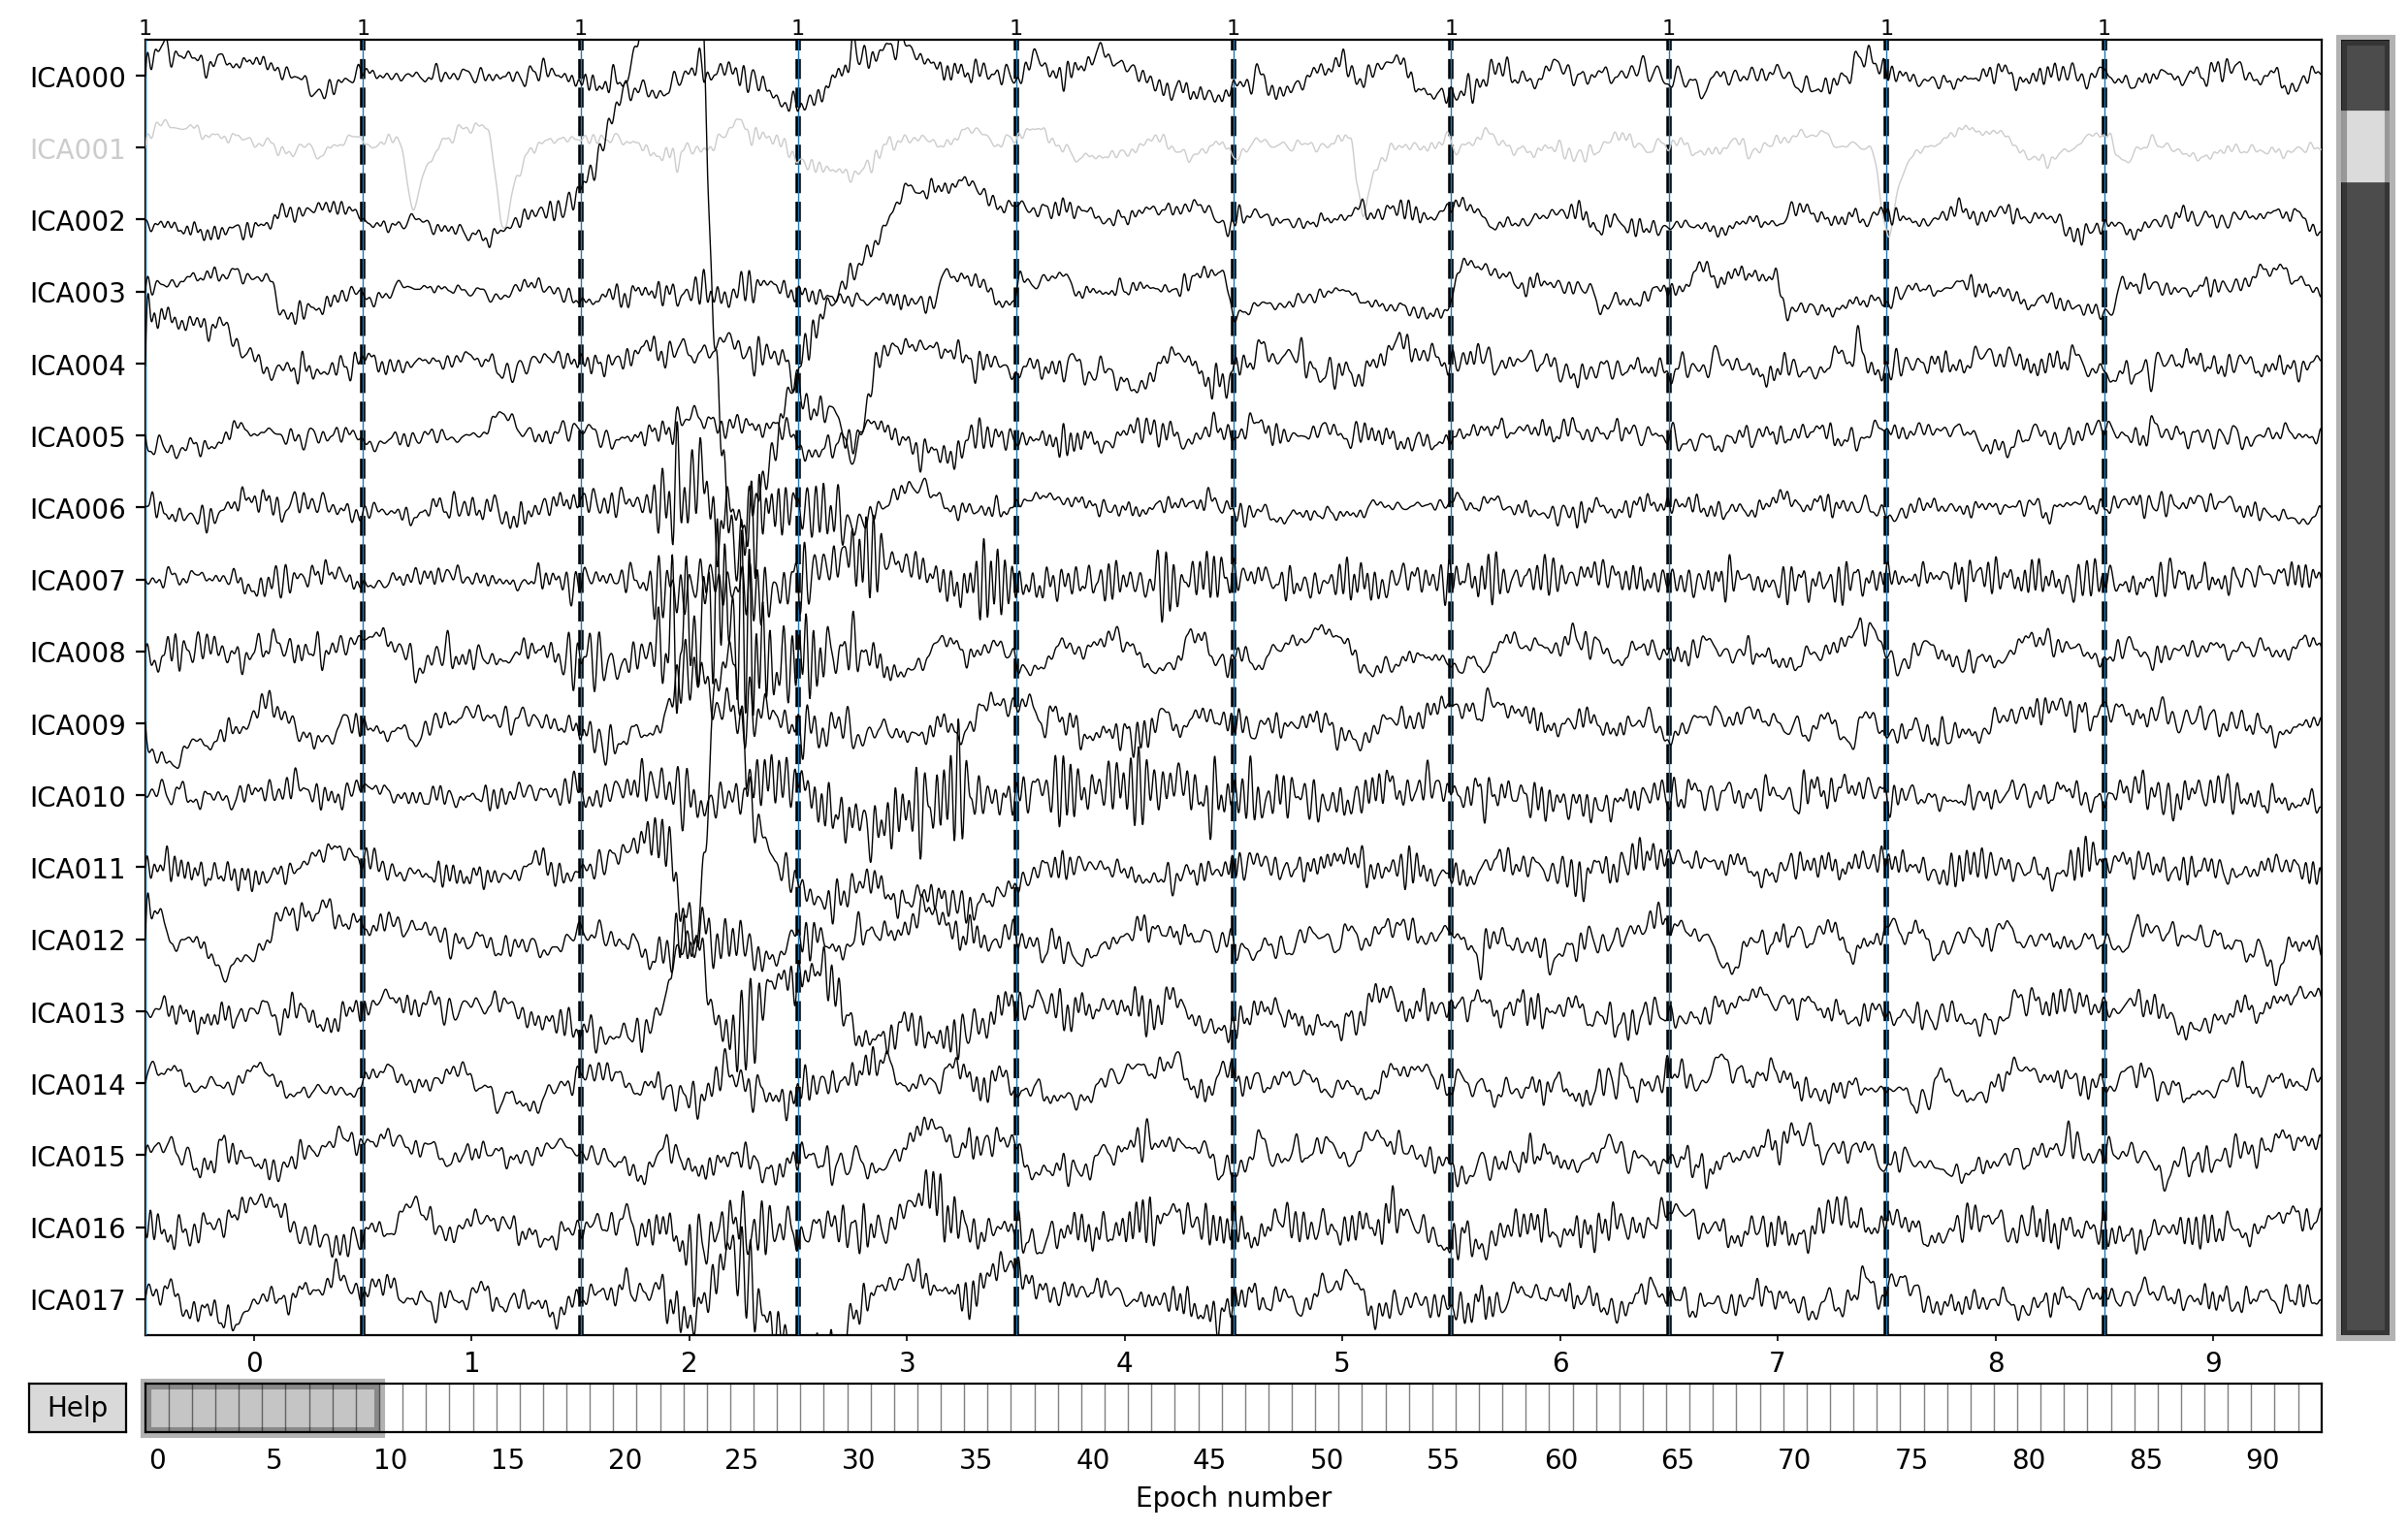

In [9]:
# Exclude components by selecting them, right click on component name to visulize source:
ica.plot_sources(epochs_faster, start=0, stop=10)

In [10]:
# After selecting the components to exclude, apply ICA to epochs
# Document the number of excluded components
ica.apply(epochs_faster)
epochs_faster.info['description'] = f'n_components: {len(ica.exclude)}'

Applying ICA to Epochs instance
    Transforming to ICA space (18 components)
    Zeroing out 2 ICA components
    Projecting back using 20 PCA components


### 1.3. Visualize ICA cleaned epochs (optional)

This step can be repeated after each preprocessing step, or you can also do a final inspection at the end. 

In [ ]:
epochs_faster.plot(n_epochs=10, scalings={'eeg': 20e-6}, title=raw.info['fid'])

### 1.4. Save cleaned epochs (recommended)

In [ ]:
# Create folder for preprocessed and interim files
folder_name = 'preprocessed'
interim_path = os.path.join(base_path, folder_name)


# Create path to epoch files
interim_epochs_path = os.path.join(interim_path, 'epochs')
if not os.path.exists(interim_epochs_path):
    os.makedirs(interim_epochs_path)

# Save ICA cleaned epochs 
fid = epochs_faster.info['fid']
epochs_clean_fname = f'{fid}_ICA'
postfix = '-epo.fif.gz'
epochs_faster.save(os.path.join(interim_epochs_path, f'{epochs_clean_fname}{postfix}'), overwrite=True)

### 2.1. Run autoreject

In [11]:
reject_log = run_autoreject(epochs_faster, n_jobs=11, subset=False)

Fitting autoreject on (n=93) epochs: 


Creating augmented epochs:  40%|████      | 8/20 [00:00<00:00, 69.56it/s]

Running autoreject on ch_type=eeg


Computing thresholds ...: 100%|██████████| 20/20 [00:00<00:00, 58.42it/s]


Repairing epochs:   0%|          | 0/93 [00:00<?, ?it/s]

Repairing epochs: 100%|██████████| 93/93 [00:00<00:00, 675.21it/s]

n_interp:   0%|          | 0/3 [00:00<?, ?it/s]

Repairing epochs:   0%|          | 0/93 [00:00<?, ?it/s]

Repairing epochs:  17%|█▋        | 16/93 [00:00<00:00, 152.01it/s]

Repairing epochs:  34%|███▍      | 32/93 [00:00<00:00, 145.59it/s]

Repairing epochs:  51%|█████     | 47/93 [00:00<00:00, 140.99it/s]

Repairing epochs:  67%|██████▋   | 62/93 [00:00<00:00, 139.53it/s]

Repairing epochs:  82%|████████▏ | 76/93 [00:00<00:00, 137.88it/s]

Repairing epochs: 100%|██████████| 93/93 [00:00<00:00, 139.82it/s]



Fold:   0%|          | 0/10 [00:00<?, ?it/s]


Fold:  10%|█         | 1/10 [00:00<00:00,  9.44it/s]


Fold:  30%|███       | 3/10 [00:00<00:00, 11.92it/s]


Fold:  50%|█████     | 5/10 [00:00<00:00, 12.37it/s]


Fold:  70%|███████   | 7/10 [00:00<00:00, 12.84it/s]


Fold: 100%|███





Estimated consensus=0.40 and n_interpolate=4


In [ ]:
# Drop bad epochs (less strict)
epochs_autoreject = epochs_faster.copy().drop(reject_log.bad_epochs, reason='AUTOREJECT')

In [ ]:
epochs_autoreject.plot(n_epochs=10,
                       n_channels=32,
                       # group_by='position',
                       scalings={'eeg': 20e-6})

In [ ]:
# save clean epochs
fid = epochs_autoreject.info['fid']
epochs_clean_fname = f'{fid}_ICA_autoreject'
postfix = '-epo.fif.gz'
epochs_autoreject.save(os.path.join(interim_epochs_path, f'{epochs_clean_fname}{postfix}'), overwrite=True)

### 3. Run ransac

In [ ]:
epochs_ransac = run_ransac(epochs_autoreject)

In [ ]:
# inspect which sensors were interpolated (if any)
epochs_ransac.info

### 4. Final visual inspection

Mark epochs that should be dropped, select electrodes that should be interpolated etc.

In [ ]:
epochs_ransac.plot(n_epochs=10,
                       n_channels=32,
                       # group_by='position',
                       scalings={'eeg': 20e-6})

In [ ]:
# if there are additional channels marked for interpolation, we can interpolate them here.
if epochs_ransac.info['bads']:
    bads_str = ', '.join(epochs_ransac.info['bads'])
    epochs_ransac.interpolate_bads()
    epochs_ransac.info.update(description=epochs_ransac.info['description'] + ', interpolated: ' + bads_str)

### 5. Set average reference

To set a “virtual reference” that is the average of all channels, you can use set_eeg_reference() with ref_channels='average'.

In [ ]:
epochs_ransac.set_eeg_reference('average')

In [ ]:
epochs_ransac.plot_drop_log()

# Save Ransac cleaned epochs 
fid = epochs_faster.info['fid']
epochs_clean_fname = f'{fid}_ICA_autoreject_ransac'
postfix = '-epo.fif.gz'
epochs_ransac.save(os.path.join(interim_epochs_path, f'{epochs_clean_fname}{postfix}'), overwrite=True)

In [ ]:
# cleanup from memory
del raw, epochs, epochs_autoreject, epochs_ransac

plt.close('all')